In [1]:
!pip install opencv-python

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-5-15 Python-3.11.12 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 



0: 448x640 1 shattered_glass, 1133.9ms
Speed: 18.0ms preprocess, 1133.9ms inference, 35.2ms postprocess per image at shape (1, 3, 448, 640)


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:907: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


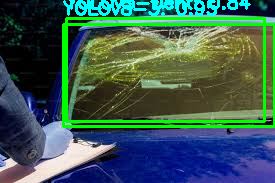

In [3]:
# Using two models
from PIL import Image
from io import BytesIO
import requests
import numpy as np
import cv2
import torch
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# Load YOLOv8 model
model_v8 = YOLO('/content/trained.pt')

# Load YOLOv5 model from torch.hub
model_v5 = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5s(1).pt', force_reload=True)

# Class names dictionary (optional, can be customized for each model)
class_names = {
    0: 'Scratch',
    1: 'Dent',
    2: 'Crack'
}

def load_image(image_path_or_url):
    if image_path_or_url.startswith('http'):
        response = requests.get(image_path_or_url)
        image_pil = Image.open(BytesIO(response.content))
    else:
        image_pil = Image.open(image_path_or_url)

    if image_pil.mode != 'RGB':
        image_pil = image_pil.convert('RGB')

    return image_pil

def draw_boxes(image_cv, boxes, class_ids, confidences, source="Model"):
    for (box, cls_id, conf) in zip(boxes, class_ids, confidences):
        x1, y1, x2, y2 = map(int, box)
        label = f"{source}-{class_names.get(cls_id, str(cls_id))}: {conf:.2f}"

        cv2.rectangle(image_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image_cv, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

def predict_with_combined_models(image_path_or_url):
    image_pil = load_image(image_path_or_url)

    # Convert PIL to OpenCV image
    image_cv = np.array(image_pil)
    image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)

    # ---------- YOLOv8 Predictions ----------
    results_v8 = model_v8(image_pil)[0]
    if results_v8.boxes is not None and len(results_v8.boxes) > 0:
        for box in results_v8.boxes:
            xyxy = box.xyxy[0].tolist()
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            draw_boxes(image_cv, [xyxy], [cls_id], [conf], source="YOLOv8")

    # ---------- YOLOv5 Predictions ----------
    results_v5 = model_v5(image_pil)
    for *xyxy, conf, cls in results_v5.xyxy[0].cpu().numpy():
        draw_boxes(image_cv, [xyxy], [int(cls)], [conf], source="YOLOv5")

    # Convert back to RGB for display in Colab
    image_rgb = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
    cv2_imshow(image_rgb)

# Run the prediction
if __name__ == "__main__":
    image_path_or_url = "/content/dcar5.jpg"  # Your image path or a URL
    predict_with_combined_models(image_path_or_url)
